In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import geopandas as gpd

In [2]:
os.chdir('data')

In [3]:
# Load the dataset (assuming it's in the same directory as the notebook)
file_path = 'fungut_metadata.tsv'  # Adjust this if necessary
df = pd.read_csv(file_path, sep='\t')  # Use tab separator for .tsv files
df.set_index('ID')
df.head()

,ID,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample
0,ERR5327198,USA,TN,36.1,-86.8,female,67,152,41,17.75,Omnivore,I do not have this condition,No
1,ERR5327199,USA,DC,38.9,-77.1,male,55.0,182.0,79.0,23.73,Omnivore,I do not have this condition,I was diagnosed with gluten allergy (anti-glut...
2,ERR5327266,USA,VA,38.9,-77.1,female,28.0,175.0,61.0,19.94,Omnivore,I do not have this condition,I do not eat gluten because it makes me feel bad
3,ERR5327282,United Kingdom,Not provided,51.6,-0.2,female,26.0,166.0,60.0,21.77,Omnivore,I do not have this condition,No
4,ERR5327284,United Kingdom,Not provided,51.5,-0.2,female,25.0,173.0,59.0,20.01,Vegetarian but eat seafood,I do not have this condition,No


In [4]:
# Convert columns to their respective data types
df['latitude_sample'] = pd.to_numeric(df['latitude_sample'], errors='coerce')   # Convert to float
df['longitude_sample'] = pd.to_numeric(df['longitude_sample'], errors='coerce')  # Convert to float
df['age_years_sample'] = pd.to_numeric(df['age_years_sample'], errors='coerce')  # Convert to float
df['height_cm_sample'] = pd.to_numeric(df['height_cm_sample'], errors='coerce')  # Convert to float
df['weight_kg_sample'] = pd.to_numeric(df['weight_kg_sample'], errors='coerce')  # Convert to float
df['bmi_sample'] = pd.to_numeric(df['bmi_sample'], errors='coerce')              # Convert to float

# Optional: Convert categorical columns to category type for optimization (optional)
df['country_sample'] = df['country_sample'].astype('category')
df['state_sample'] = df['state_sample'].astype('category')
df['sex_sample'] = df['sex_sample'].astype('category')
df['diet_type_sample'] = df['diet_type_sample'].astype('category')
df['ibd_sample'] = df['ibd_sample'].astype('category')
df['gluten_sample'] = df['gluten_sample'].astype('category')

# Display the updated data types
print("\nUpdated data types:")
print(df.dtypes)


Updated data types:
ID                    object
country_sample      category
state_sample        category
latitude_sample      float64
longitude_sample     float64
sex_sample          category
age_years_sample     float64
height_cm_sample     float64
weight_kg_sample     float64
bmi_sample           float64
diet_type_sample    category
ibd_sample          category
gluten_sample       category
dtype: object


In [5]:
urban_areas = gpd.read_file('urban_areas/ne_10m_urban_areas.shp')

In [6]:
# Set CRS of gdf to EPSG:4326 (WGS 84)
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df['longitude_sample'], df['latitude_sample']),
                       crs="EPSG:4326")

In [7]:
# If urban_areas is not already in EPSG:4326, reproject it
if urban_areas.crs != "EPSG:4326":
    urban_areas = urban_areas.to_crs("EPSG:4326")

In [8]:

# 4. Perform spatial join and classify points as urban or rural
gdf['is_urban'] = gpd.sjoin(gdf, urban_areas, predicate='within', how='left').index_right.notnull()


In [9]:
# Add the 'urban' classification back to df
df['urban'] = gdf['is_urban']

In [10]:
print(df[['longitude_sample', 'latitude_sample', 'urban']].head())


   longitude_sample  latitude_sample  urban
0             -86.8             36.1   True
1             -77.1             38.9   True
2             -77.1             38.9   True
3              -0.2             51.6   True
4              -0.2             51.5   True


/tmp/ipykernel_941/2365269253.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


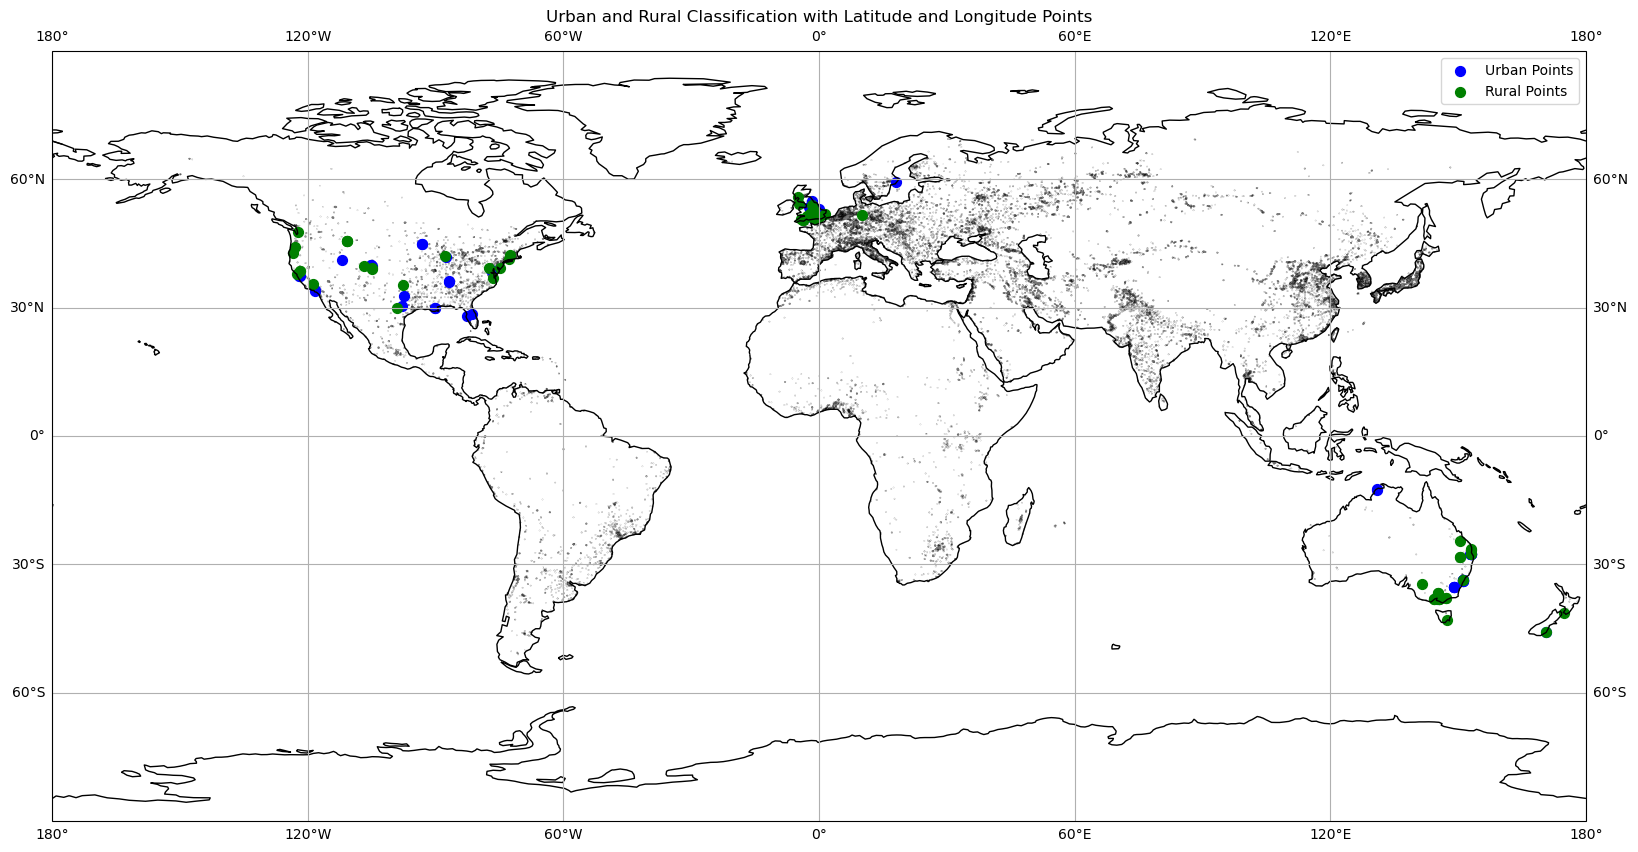

<Figure size 640x480 with 0 Axes>

In [13]:
# 5. Visualization (All in one cell)
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot urban areas
urban_areas.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Urban Area')

# Plot points: urban in blue, rural in green
gdf[gdf['is_urban']].plot(ax=ax, color='blue', markersize=50, label='Urban Points')
gdf[~gdf['is_urban']].plot(ax=ax, color='green', markersize=50, label='Rural Points')

# Add a legend
plt.legend()
plt.title('Urban and Rural Classification with Latitude and Longitude Points')
plt.show()
plt.savefig('../plots/geographical_distribution_classified.png')
